In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

plt.style.use('seaborn')
from matplotlib import rc, font_manager
style.use("fivethirtyeight")
style.use("seaborn-talk")
plt.rcParams['font.family'] = 'serif'

import pickle
import os
import re
import json

from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

# wiki

In [8]:
with open(os.path.join("../data/wikipedia_documents.json"), "r", encoding="utf-8") as f:
    wiki = json.load(f)
wiki['0'].keys()

dict_keys(['text', 'corpus_source', 'url', 'domain', 'title', 'author', 'html', 'document_id'])

In [9]:
wiki = pd.DataFrame(wiki).T
wiki.head()

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [10]:
len(wiki)

60613

# train/valid

In [11]:
#pip install datasets==2.12.0

In [13]:
# train_dataset을 불러오고 싶은 경우
from datasets import load_from_disk
train_dataset = load_from_disk("../data/train_dataset/")

In [14]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})

- id: 질문의 고유 id
- question: 질문
- answers: 답변에 대한 정보. 하나의 질문에 하나의 답변만 존재함
    - answer_start : 답변의 시작 위치
    - text: 답변의 텍스트
- context: 답변이 포함된 문서
- title: 문서의 제목
- document_id: 문서의 고유 id

In [15]:
train=pd.DataFrame({'title':train_dataset['train']['title'], 'context':train_dataset['train']['context'], 'question':train_dataset['train']['question'], 'id':train_dataset['train']['id'], 'answers':train_dataset['train']['answers'], 'document_id':train_dataset['train']['document_id'], '__index_level_0__':train_dataset['train']['__index_level_0__']})
valid=pd.DataFrame({'title':train_dataset['validation']['title'], 'context':train_dataset['validation']['context'], 'question':train_dataset['validation']['question'], 'id':train_dataset['validation']['id'], 'answers':train_dataset['validation']['answers'], 'document_id':train_dataset['validation']['document_id'], '__index_level_0__':train_dataset['validation']['__index_level_0__']})

In [23]:
print("--train--")
print(len(train), train.columns, '\n')

print("--valid--")
print(len(valid), valid.columns)


--train--
3952 Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__'],
      dtype='object') 

--valid--
240 Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__'],
      dtype='object')


In [20]:
train.head()

,title,context,question,id,answers,document_id,__index_level_0__
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548


# 1. context 길이

In [107]:
# 단순한 len으로 길이 재기 - train
def splitter(string):
    return string.split()

def context_length(tokenizer, text):
    if tokenizer is None:
        tokenizer = splitter
        result = tokenizer(text)
    else:
        result = tokenizer(text,
                           max_length = 2048,
                           truncation=True,
                           # padding="max_length",
                           ).input_ids
    
    return len(result)//10 * 10

train_df = train.copy()

# # 단순한 splitter
# 
# train_df['context_length'] = train_df['context'].apply(lambda x:context_length(None, x))
# train_df.head(3)

# klue-bert tokenizer로 토큰 길이 확인하기
# klue-bert 토크나이저
from transformers import AutoTokenizer

model_name = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_df['context_length'] = train_df['context'].apply(lambda x:context_length(tokenizer, x))
train_df.head(3)


,title,context,question,id,answers,document_id,__index_level_0__,context_length
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42,430
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873,320
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230,460


[Text(0, 0, '240'),
 Text(1, 0, '250'),
 Text(2, 0, '260'),
 Text(3, 0, '270'),
 Text(4, 0, '280'),
 Text(5, 0, '290'),
 Text(6, 0, '300'),
 Text(7, 0, '310'),
 Text(8, 0, '320'),
 Text(9, 0, '330'),
 Text(10, 0, '340'),
 Text(11, 0, '350'),
 Text(12, 0, '360'),
 Text(13, 0, '370'),
 Text(14, 0, '380'),
 Text(15, 0, '390'),
 Text(16, 0, '400'),
 Text(17, 0, '410'),
 Text(18, 0, '420'),
 Text(19, 0, '430'),
 Text(20, 0, '440'),
 Text(21, 0, '450'),
 Text(22, 0, '460'),
 Text(23, 0, '470'),
 Text(24, 0, '480'),
 Text(25, 0, '490'),
 Text(26, 0, '500'),
 Text(27, 0, '510'),
 Text(28, 0, '520'),
 Text(29, 0, '530'),
 Text(30, 0, '540'),
 Text(31, 0, '550'),
 Text(32, 0, '560'),
 Text(33, 0, '570'),
 Text(34, 0, '580'),
 Text(35, 0, '590'),
 Text(36, 0, '600'),
 Text(37, 0, '610'),
 Text(38, 0, '620'),
 Text(39, 0, '630'),
 Text(40, 0, '640'),
 Text(41, 0, '650'),
 Text(42, 0, '660'),
 Text(43, 0, '670'),
 Text(44, 0, '680'),
 Text(45, 0, '690'),
 Text(46, 0, '700'),
 Text(47, 0, '710'),
 T

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


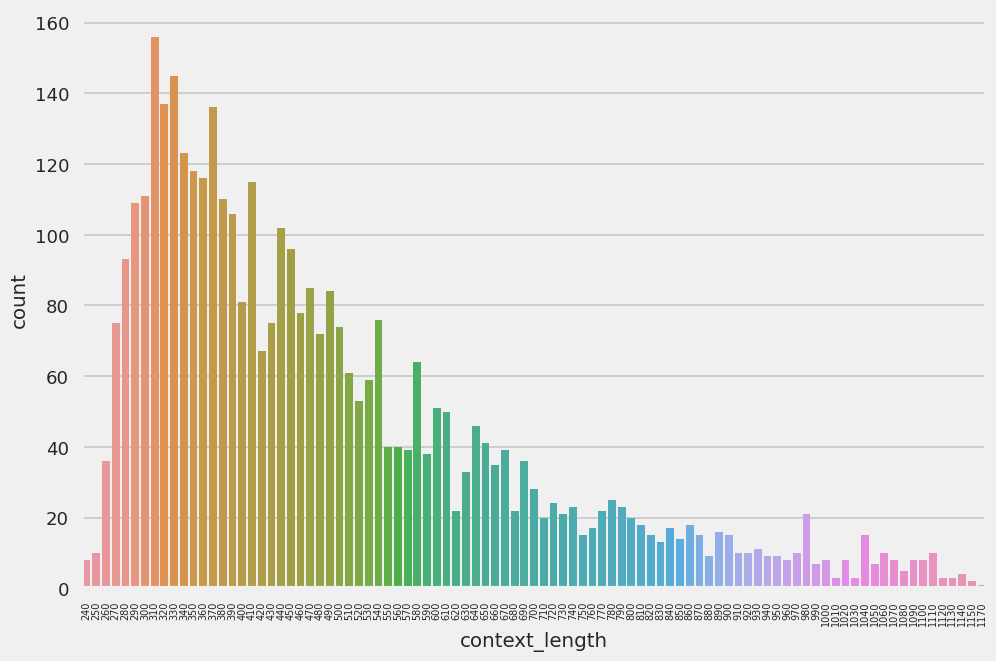

In [64]:
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x=train_df['context_length'], data=train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7)

In [89]:
# minimal length context 보기 - 예시 1
from pprint import pprint
print("Minimal length of context: ")
pprint(train_df.loc[train_df['context_length'].idxmin(), 'context'])
print("Length of this context: ", train_df.loc[train_df['context_length'].idxmin(), 'context_length'])

# minimal length인 애들 전체 개수
clen_min_around = train_df[train_df['context_length'] <= 250]
clen_min_around_len = len(clen_min_around)
print("\nnumber of shorter than 250(from tokenizer): ", clen_min_around_len, "개")

Minimal length of context: 
('아일랜드는 미국과 협업하기 편리한 시간대에 위치하고 있으며, 미국의 노동자들이 잠들어있는 시간 동안 아일랜드 노동자들이 일상 업무의 전반 '
 '부분을 해낼 수 있다. 이것은 특히 법무, 재무 부서를 가진 기업에 유용하며 예를 들어 미국의 변호사가 잠자는 시간에 아일랜드의 변호사가 '
 '소송에 대한 작업을 할 수 있다. 또한 미국 기업들이 생각하기에 아일랜드는 다른 유럽 연합 회원국, 특히 동유럽 국가에 비해 정부의 '
 '개입이 적다는 것도 매력이었다. 또한 성 금요일 합의에 의해 북아일랜드 정세가 안정화 된 것으로, 아일랜드는 안정된 경제 활동 환경을 '
 '정돈할 수 있었다. \\n\\n아일랜드는 포르투갈이나 스페인 등 인건비가 낮은 다른 유럽 연합 회원국의 노동자에 비해 즉시 영어로 대화 '
 '할 수 있는 이점이 있으며, 이것은 미국 기업들이 아일랜드의 노동자를 선택하는 이유 중 하나이다. 또한 출산율이 낮기 때문에 노동 인구 '
 '비율이 증가 인구배당효과의 상태나, 여성의 노동 시장 참여 등도 인구 1인당 소득 증가로 이어지고 있다고도 지적되고 있다.')
Length of this context:  240

number of shorter than 250(from tokenizer):  18 개


In [91]:
# max 한번 봐보기

print("Minimal length of context: ")
pprint(train_df.loc[train_df['context_length'].idxmax(), 'context'])
print("Length of this context: ", train_df.loc[train_df['context_length'].idxmax(), 'context_length'])

# minimal length인 애들 전체 개수
clen_max_around = train_df[train_df['context_length'] >= 1000]
clen_max_around_len = len(clen_max_around)
print("\nnumber of shorter than 250(from tokenizer): ", clen_max_around_len, "개")

Minimal length of context: 
('아니메 《기동전사 건담》에서는 솔로몬 공략전 후 제37화에서 샤아가 조종하는 신형 모빌슈트로서 최초 등장했다. 당시 기체는 샤아 '
 '전용기라는 의미를 가지고 있었기 때문에 붉은 색을 기조로 도장되어 있었다. 그 다음 화에서는 텍사스 콜로니에서 건담과 격렬한 싸움을 '
 '연출하지만 손상으로 후퇴하고 만다.\\n그 후 엘메스과 동시에 수회 출격했으며, 제41화에서 샤아의 겔구그는 오른 팔을 건담의 빔 사벨 '
 '공격에 잃고 엘메스마저 잃은 채 후퇴하고 만다(덧붙여, 이 당시 장면은 리메이크되어 《기동전사 건담 역습의 샤아》에서 회상 장면으로서 '
 '재등장한다).\\n\\n또한 일년전쟁 최종 결전인 아 바오아 쿠 공략전이 시작되는 제42화에서는 녹색을 기조로 도장된 양산기가 등장해 '
 '겔구그는 샤아만이 탑승하는 기체가 아닌 복수 양산된 기체라는 인상이 부여되었다. 또한 다음 화인 제43화가 최종회였기 때문에 전선 투입이 '
 '늦은 신형 병기라는 인상도 주었다.\\n\\n아니메 《기동전사 Z 건담》에서는 제26화「지온의 망령」에서 손상을 입고 방기되어 있던 구 '
 '지온 공국군 전함「그와덴」안에 역시 같이 방기되어 있던 모빌슈트로서 자이언트 바주카를 장비한 녹색의 겔구그가 등장한다. 이 기체에 카츠 '
 '고바야시가 탑승해 야잔 게블의 가프랑에게 쫓기고 있던 카미유 비단의 Z 건담을 구출했다. 당시 기체는 회수되어 아가마에서 수리(네모의 '
 '부품을 이식했다)되어 레코아 론드가 쥬피트리스에 침입할 당시 사용되기도 하고 메가 바주카 런처의 추가 에너지 제너레이터 용도로서 '
 '이용되기도 하는 등 여러 차례 등장한다.\\n\\n아니메 《기동전사 ZZ 건담》에서는 아프리카 민족해방전선 소속 게릴라인 청색 부대에서 '
 '대장 데도 카루토하 및 에로 메로에 일행이 겔구그(극중 대사로 봐서는 오리지널이 아닌 레플리카인 듯하다)를 탑승하고 등장한다. 청색 부대 '
 '소속의 다른 기체와 함께 부대색인 청색

[Text(0, 0, '260'),
 Text(1, 0, '270'),
 Text(2, 0, '280'),
 Text(3, 0, '290'),
 Text(4, 0, '300'),
 Text(5, 0, '310'),
 Text(6, 0, '320'),
 Text(7, 0, '330'),
 Text(8, 0, '340'),
 Text(9, 0, '350'),
 Text(10, 0, '360'),
 Text(11, 0, '370'),
 Text(12, 0, '380'),
 Text(13, 0, '390'),
 Text(14, 0, '400'),
 Text(15, 0, '410'),
 Text(16, 0, '420'),
 Text(17, 0, '430'),
 Text(18, 0, '440'),
 Text(19, 0, '450'),
 Text(20, 0, '460'),
 Text(21, 0, '470'),
 Text(22, 0, '480'),
 Text(23, 0, '490'),
 Text(24, 0, '500'),
 Text(25, 0, '510'),
 Text(26, 0, '520'),
 Text(27, 0, '530'),
 Text(28, 0, '540'),
 Text(29, 0, '550'),
 Text(30, 0, '560'),
 Text(31, 0, '570'),
 Text(32, 0, '580'),
 Text(33, 0, '590'),
 Text(34, 0, '600'),
 Text(35, 0, '610'),
 Text(36, 0, '620'),
 Text(37, 0, '630'),
 Text(38, 0, '640'),
 Text(39, 0, '650'),
 Text(40, 0, '660'),
 Text(41, 0, '680'),
 Text(42, 0, '690'),
 Text(43, 0, '700'),
 Text(44, 0, '710'),
 Text(45, 0, '730'),
 Text(46, 0, '740'),
 Text(47, 0, '750'),
 T

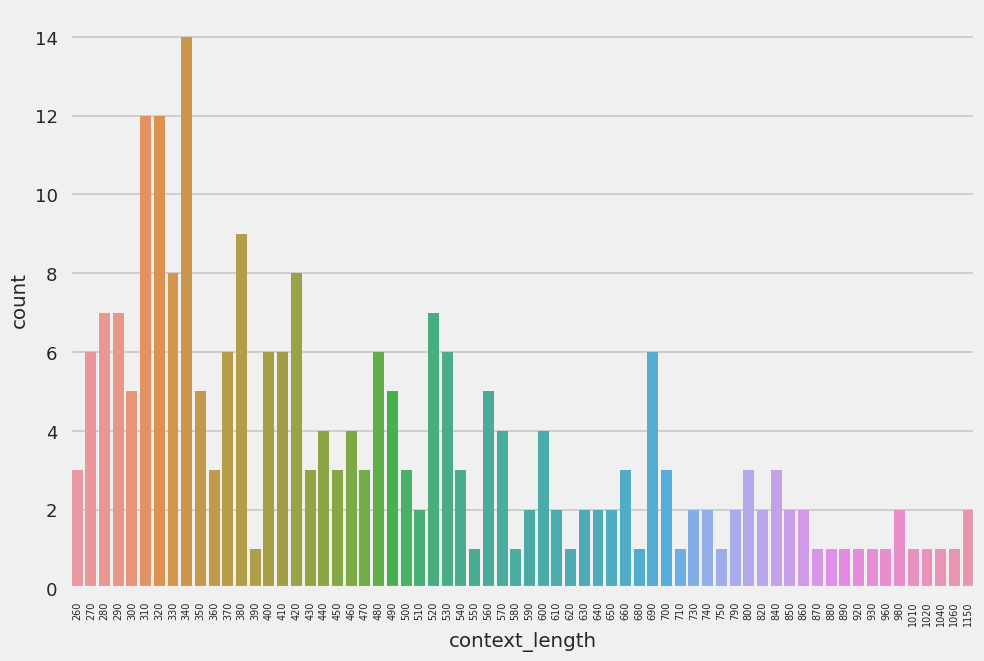

In [120]:
# valid context 시각화

valid_df = valid.copy()
valid_df['context_length'] = valid_df['context'].apply(lambda x:context_length(tokenizer, x))
valid_df.head(3)

ax = sns.countplot(x=valid_df['context_length'], data=valid_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=7)

In [172]:
# train, valid 는 context 길이 측면에서 차이가 없다.

# 2. Answer 길이

In [127]:
print(tokenizer("하원").input_ids)
print(tokenizer.convert_ids_to_tokens(3))

[2, 11119, 3]
[SEP]


In [124]:
def extract_answer_text(string):
    return string['text'][0]

tokenizer = AutoTokenizer.from_pretrained(model_name)
train_df['answer_text'] = train_df['answers'].apply(lambda x: extract_answer_text(x))
train_df['answer_length'] = train_df['answer_text'].apply(lambda x:len(tokenizer(str(x)).input_ids))

valid_df['answer_text'] = valid_df['answers'].apply(lambda x: extract_answer_text(x))
valid_df['answer_length'] = valid_df['answer_text'].apply(lambda x:len(tokenizer(str(x)).input_ids))

train_df.head(5)

,title,context,question,id,answers,document_id,__index_level_0__,context_length,answer_text,answer_length
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42,430,하원,3
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873,320,《경영의 실제》,7
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230,460,백성,3
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992,410,중국,3
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548,340,4개,4


[Text(0, 0, '3'),
 Text(1, 0, '4'),
 Text(2, 0, '5'),
 Text(3, 0, '6'),
 Text(4, 0, '7'),
 Text(5, 0, '8'),
 Text(6, 0, '9'),
 Text(7, 0, '10'),
 Text(8, 0, '11'),
 Text(9, 0, '12'),
 Text(10, 0, '13'),
 Text(11, 0, '14'),
 Text(12, 0, '15'),
 Text(13, 0, '16'),
 Text(14, 0, '17'),
 Text(15, 0, '18'),
 Text(16, 0, '19'),
 Text(17, 0, '20'),
 Text(18, 0, '21'),
 Text(19, 0, '23'),
 Text(20, 0, '25'),
 Text(21, 0, '26'),
 Text(22, 0, '28'),
 Text(23, 0, '29'),
 Text(24, 0, '36'),
 Text(25, 0, '37'),
 Text(26, 0, '51')]

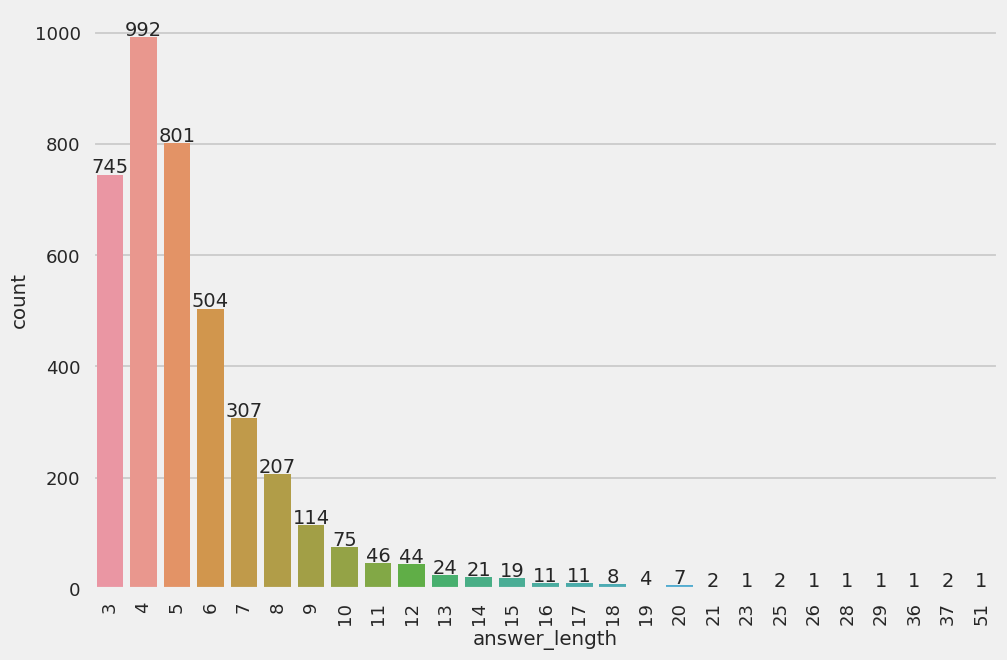

In [147]:
# train context 시각화

ax = sns.countplot(x=train_df['answer_length'], data=train_df)
for p in ax.patches:
    ax.annotate(text=format(p.get_height(), '.0f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points',
                )

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '3'),
 Text(1, 0, '4'),
 Text(2, 0, '5'),
 Text(3, 0, '6'),
 Text(4, 0, '7'),
 Text(5, 0, '8'),
 Text(6, 0, '9'),
 Text(7, 0, '10'),
 Text(8, 0, '11'),
 Text(9, 0, '12'),
 Text(10, 0, '13'),
 Text(11, 0, '14'),
 Text(12, 0, '15'),
 Text(13, 0, '17'),
 Text(14, 0, '18'),
 Text(15, 0, '19'),
 Text(16, 0, '21'),
 Text(17, 0, '22'),
 Text(18, 0, '32')]

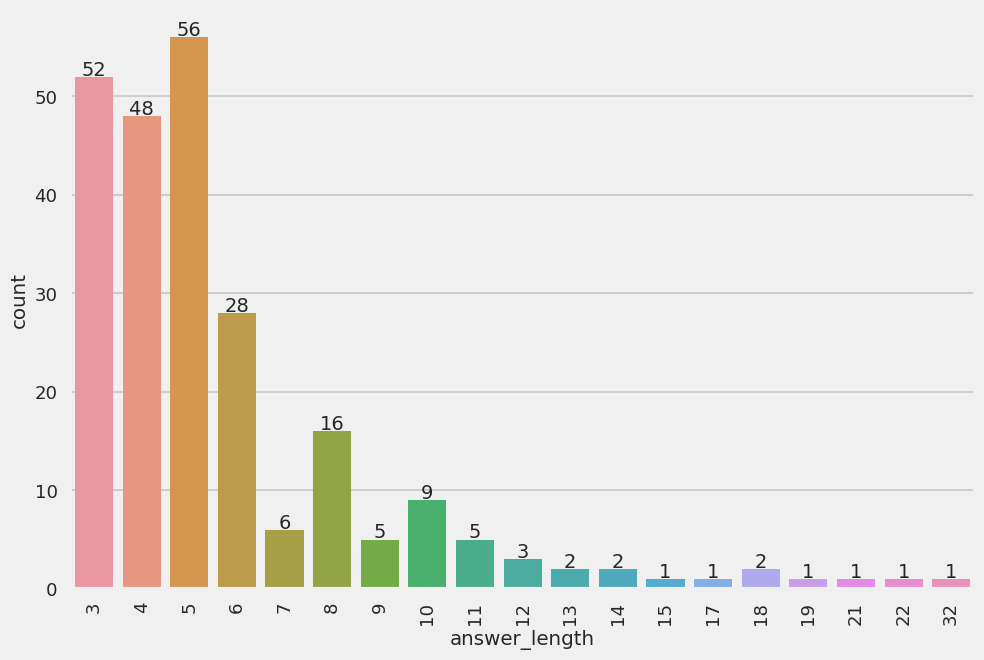

In [162]:
# valid answer 시각화

ax = sns.countplot(x=valid_df['answer_length'], data=valid_df)
for p in ax.patches:
    ax.annotate(text=format(p.get_height(), '.0f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points',
                )

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [171]:
length_4_test = train_df[train_df['answer_length']==4]["answer_text"].tolist()[6]
print("\n길이가 4인 answer : ", length_4_test)
print("tokenizer 결과: ", tokenizer(length_4_test).input_ids, tokenizer.convert_ids_to_tokens(tokenizer(length_4_test).input_ids))


길이가 4인 answer :  1945년
tokenizer 결과:  [2, 12883, 2440, 3] ['[CLS]', '1945', '##년', '[SEP]']


In [161]:
# 가장 짧은 단어 -> "하원" -> [CLS] 하원 [SEP]
# 그다음 길이의 단어 -> "다산 정약용", "1945년"
# trian에서 가장 긴 단어 확인하기
print("--- train ---")
print("가장 긴 answer : ", train_df.loc[train_df['answer_length'].idxmax(), "answer_text"])
print("해당 answer의 길이: ", train_df.loc[train_df['answer_length'].idxmax(), "answer_length"])
print("해당 query: ", train_df.loc[train_df['answer_length'].idxmax(), "question"])

print("\n두 번째로 긴 answer : ", train_df[train_df['answer_length']==37]["answer_text"].tolist()[0])
print("해당 answer의 길이: ", train_df.loc[train_df['answer_length']==37, "answer_length"].tolist()[0])
print("해당 query: ", train_df.loc[train_df['answer_length']==37, "question"].tolist()[0])

print("\n--- valid ---")
print("가장 긴 answer : ", train_df.loc[train_df['answer_length'].idxmax(), "answer_text"])
print("해당 answer의 길이: ", train_df.loc[train_df['answer_length'].idxmax(), "answer_length"])
print("해당 query: ", train_df.loc[train_df['answer_length'].idxmax(), "question"])

print("\n두 번째로 긴 answer : ", train_df[train_df['answer_length']==37]["answer_text"].tolist()[0])
print("해당 answer의 길이: ", train_df.loc[train_df['answer_length']==37, "answer_length"].tolist()[0])
print("해당 query: ", train_df.loc[train_df['answer_length']==37, "question"].tolist()[0])

가장 긴 answer :  “나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”
해당 answer의 길이:  51
해당 query:  윤치호가 일부 독립운동 지도자들로부터 비난 받았던 일기의 내용은?

두 번째로 긴 answer :  형태에 있어 거의 혹은 전혀 자유가 없어 다양한 번역을 창조해내기가 불가능하고 시구 구조에서도 다른 여지를 찾기 어려운 탓이다.
해당 answer의 길이:  37
해당 query:  노랫말의 번역이 대구 시구 번역보다 훨씬 제약이 많은 이유는?


# 3. context - question의 개수 정도 분포

In [173]:
train_df.columns

Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__', 'context_length', 'answer_text', 'answer_length'],
      dtype='object')

In [178]:
train_df[train_df.duplicated(subset=['context'])]['context']

68      1894년 장위영 영관을 지낸 무관이었다. 1896년 명성황후가 일본인 낭인들에게 ...
292     하느님이시요 사람이신 그리스도의 시\n1943년부터 1951년까지 마리아 발토르타는...
320     1878년 10월 21일 조선 충청북도 증평에서 태어난 그는 형제로는 독립운동가 연...
327     선언형 프로그래밍은 두 가지 뜻으로 통용되고 있다.\n\n한 정의에 따르면, 프로그...
337     경북 선산에서 태어나 경성부의 중앙고등보통학교를 졸업했다. 화가 이종우에게 수학한 ...
                              ...                        
3943    진실규명 결정을 받은 김지태의 유가족들은 2010년 6월에야 법원에 정수장학회와 국...
3946    628년에 당이 마지막 남은 군벌 세력과 서돌궐을 제거하고 통일하였듯, 당의 성장을...
3947    이오의 산\n이오의 산 목록\n 이오에는 100~150개의 산이 있다. 이들 산의 ...
3950    원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...
3951    2008년 2월 28일 실시된 2008년 함부르크 주의회 선거에서 기민련은 과반수 ...
Name: context, Length: 612, dtype: object

In [189]:
grouped_df = train_df.groupby(['context'])

for context, group in grouped_df:
    if len(group) > 3:
        print(group[['context', 'question']])
    

                                                context  \
201   그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...   
1426  그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...   
1622  그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...   
2199  그러나 한편으로는 미국 사회의 인종차별주의적, 흑인을 차별하는 태도를 목격하면서 백...   

                                             question  
201   평상시 기독교선교사들로부터 차별적 대우를 받은 윤치호가 생각한 미국의 중대한 속성은?  
1426                 윤치호가 미국의 특징이 인종주의라고 생각하게 만든 인물은?  
1622                 조선에서도 윤치호를 유색 인종이라는 이유로 차별한 사람은?  
2199                         윤치호는 누구의 설교를 듣고 충격을 받았나?  


In [193]:
grouped_df = valid_df.groupby(['context'])

for context, group in grouped_df:
    if len(group) > 1:
        print(len(group))
        print(group[['context', 'question']])
        
# -> valid같은 경우 context가 중복되는 경우는 단 5건 만 존재한다. 그것도 question이 같은 context에 최대 2개만 존재한다.

2
                                               context  \
74   러셀은 1890년 케임브리지 대학교의 트리니티 칼리지에 장학생으로 들어갔다. 그는 ...   
231  러셀은 1890년 케임브리지 대학교의 트리니티 칼리지에 장학생으로 들어갔다. 그는 ...   

                              question  
74                     러셀의 여자 친구의 종교는?  
231  러셀은 누구의 가족과 함께 1889년 파리 박람회에 갔는가?  
2
                                              context  \
6   수를 놓을 때에 사용하는 기법을 문양의 형태에 따라 나누어 보면 선을 잇는 수, 면...   
81  수를 놓을 때에 사용하는 기법을 문양의 형태에 따라 나누어 보면 선을 잇는 수, 면...   

                                  question  
6         징금수는 서양 자수의 어떤 기법과 같은 기술을 사용하는가?  
81  수를 놓을 때에 사용하는 기법 중 아주 작은 점으로 표현하는 방식은?  
2
                                               context  \
129  요나라와의 전연의 맹세에 지불한 것으로 알려진 재물은 비단 20만필, 은 10만량이...   
205  요나라와의 전연의 맹세에 지불한 것으로 알려진 재물은 비단 20만필, 은 10만량이...   

                            question  
129         송나라가 돈을 지불하여 피하고자 했던 것은?  
205  송이 금에게 바친 공물은 은 30만량과 비단 몇 필인가?  
2
                                               context  \
162  태양권계면(Heliopause)은 천문학에서 태양의 태양풍

In [202]:
print("total duplicated: ", len(train_df[train_df.duplicated(subset=['context'])]))


total duplicated:  612


In [180]:
# Count the duplicated 'context' rows with different 'answer' and 'question' values
duplicated_context_count = train_df[train_df.duplicated(subset=['context'], keep=False) &
                                    ~train_df.duplicated(subset=['context', 'answer_text', 'question'], keep=False)].shape[0]

# Print the count
print("Count of duplicated 'context' rows with different 'answer' and 'question' values:", duplicated_context_count)


Count of duplicated 'context' rows with different 'answer' and 'question' values: 1191


# 4. 추가해볼만한 EDA는...
- context-question 자체에서의 TF-IDF 수치 확인하기

In [215]:
from sklearn.feature_extraction.text import TfidfVectorizer
# model_name = 'klue/bert-base'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer_func = lambda x: x.split(' ')
vectorizer = TfidfVectorizer(tokenizer=tokenizer_func, ngram_range=(1,2))

# corpus
corpus = list(set([example['context'] for _, example in train_df.iterrows()]))
print(f"org train len: {len(train_df)}, after set: {len(corpus)}")


org train len: 3952, after set: 3340


In [217]:
# TF-IDF training
vectorizer.fit(corpus)
sp_matrix = vectorizer.transform(corpus)

print(sp_matrix.shape)

(3340, 842301)


In [218]:
import pandas as pd
df = pd.DataFrame(sp_matrix[0].T.todense(), index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print(df.head(10))

        TF-IDF
밀본이   0.253834
병을    0.091478
와서    0.085129
김유신의  0.084611
밀본을   0.084611
귀신들을  0.084611
인혜는   0.084611
거사는   0.084611
나았다.  0.080537
병은    0.080537


In [233]:
# query 각각을 tf-idf vector로 변환

query_test = train_df['question'][1]
ground_truth = train_df['context'][1]

query_vec = vectorizer.transform([query_test])
doc_vec = vectorizer.transform([ground_truth])
print(query_vec.shape, doc_vec.shape, query_vec*doc_vec.T)


result = query_vec*sp_matrix.T
print(query_vec.shape, doc_vec.shape, "ground truth가 아닌 문서와는:",result.data[np.argsort(-result.data)][1:3])


(1, 842301) (1, 842301)   (0, 0)	0.24035603265897992
(1, 842301) (1, 842301) ground truth가 아닌 문서와는: [0.02916644 0.02587913]


In [234]:
# 음... question이 애초에 context의 단어들을 너무 많이 가져오는 게 아닌가 하는 의심은 어떻게 해야하지?

In [236]:
train_df.loc[0, :]

title                                                            미국 상원
context              미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...
question                              대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?
id                                                        mrc-1-000067
answers                        {'answer_start': [235], 'text': ['하원']}
document_id                                                      18293
__index_level_0__                                                   42
context_length                                                     430
answer_text                                                         하원
answer_length                                                        3
Name: 0, dtype: object

In [241]:
def cal_tf_idf_score(row):
    query_test = row['question']
    ground_truth = row['context']

    query_vec = vectorizer.transform([query_test])
    doc_vec = vectorizer.transform([ground_truth])
    
    return query_vec*doc_vec.T

# 약 30-60초 소요
train_df['tf_idf_score'] = train_df.apply(lambda x:cal_tf_idf_score(x), axis=1)
train_df.head(4)

,title,context,question,id,answers,document_id,__index_level_0__,context_length,answer_text,answer_length,tf_idf_score
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42,430,하원,3,"(0, 0)\t0.07221097856687125"
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873,320,《경영의 실제》,7,"(0, 0)\t0.24035603265897992"
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230,460,백성,3,"(0, 0)\t0.01012734497886054"
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992,410,중국,3,


In [268]:
from tqdm import tqdm

train_df['tf_idf_score'] = [0.0]*len(train_df)
for idx, row in tqdm(train_df.iterrows(), desc="tf_idf 점수 계산중입니다"):
    # if idx > 5: break
    query_test = row['question']
    ground_truth = row['context']

    query_vec = vectorizer.transform([query_test])
    doc_vec = vectorizer.transform([ground_truth])
    result = query_vec*doc_vec.T
    #print(result.data.shape, result.data[0], result.data.size)
    
    if result.data.size:
        train_df.loc[idx, 'tf_idf_score'] = round(result.data[0], 2)
    else:
        train_df.loc[idx, 'tf_idf_score'] = 0.0

tf_idf 점수 계산중입니다: 3952it [00:34, 113.79it/s]


In [269]:
train_df.head(5)

,title,context,question,id,answers,document_id,__index_level_0__,context_length,answer_text,answer_length,tf_idf_score
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42,430,하원,3,0.07
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873,320,《경영의 실제》,7,0.24
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230,460,백성,3,0.01
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992,410,중국,3,0.00
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548,340,4개,4,0.06


[Text(0, 0, '0.0'),
 Text(1, 0, '0.01'),
 Text(2, 0, '0.02'),
 Text(3, 0, '0.03'),
 Text(4, 0, '0.04'),
 Text(5, 0, '0.05'),
 Text(6, 0, '0.06'),
 Text(7, 0, '0.07'),
 Text(8, 0, '0.08'),
 Text(9, 0, '0.09'),
 Text(10, 0, '0.1'),
 Text(11, 0, '0.11'),
 Text(12, 0, '0.12'),
 Text(13, 0, '0.13'),
 Text(14, 0, '0.14'),
 Text(15, 0, '0.15'),
 Text(16, 0, '0.16'),
 Text(17, 0, '0.17'),
 Text(18, 0, '0.18'),
 Text(19, 0, '0.19'),
 Text(20, 0, '0.2'),
 Text(21, 0, '0.21'),
 Text(22, 0, '0.22'),
 Text(23, 0, '0.23'),
 Text(24, 0, '0.24'),
 Text(25, 0, '0.25'),
 Text(26, 0, '0.26'),
 Text(27, 0, '0.27'),
 Text(28, 0, '0.28'),
 Text(29, 0, '0.29'),
 Text(30, 0, '0.3'),
 Text(31, 0, '0.31'),
 Text(32, 0, '0.32'),
 Text(33, 0, '0.33'),
 Text(34, 0, '0.34'),
 Text(35, 0, '0.35'),
 Text(36, 0, '0.36'),
 Text(37, 0, '0.37'),
 Text(38, 0, '0.38'),
 Text(39, 0, '0.4'),
 Text(40, 0, '0.41'),
 Text(41, 0, '0.42'),
 Text(42, 0, '0.43'),
 Text(43, 0, '0.44'),
 Text(44, 0, '0.46'),
 Text(45, 0, '0.47'),
 Te

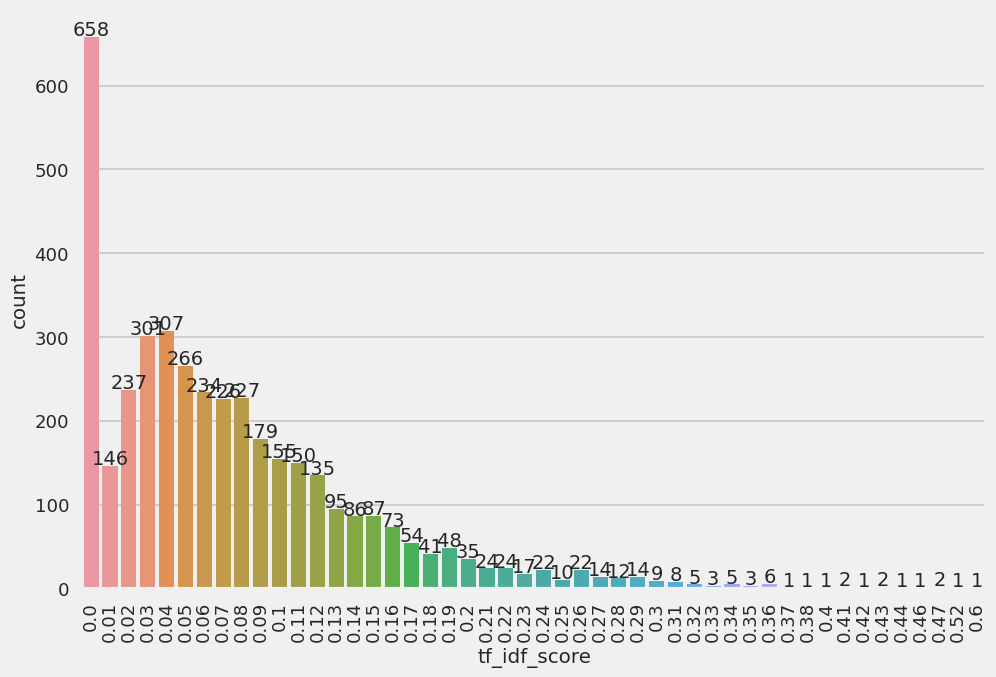

In [270]:
# train tf idf 시각화

ax = sns.countplot(x=train_df['tf_idf_score'], data=train_df)
for p in ax.patches:
    ax.annotate(text=format(p.get_height(), '.0f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points',
                )

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [281]:
model_name = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_df['question_length'] = train_df['question'].apply(lambda x:context_length(tokenizer, x))

In [282]:
train_df[train_df['tf_idf_score'] > 0.5][['context', 'question', 'question_length']]

,context,question,question_length
946,"스페인은 피레네 산맥, 시스테마 센트럴 산맥, 세스테마 이베리코 산맥, 시에라 네바...",시에라 네바다 산맥에서 할 수 있는 스포츠는?,10
2956,제파 디 미노는 시에나에 사는 매우 유복한 평민이었다. 그에게는 항상 친하게 지내는...,제파 디 미노는 친구의 아내에게 함께 복수하기를 부탁하며 무엇을 건네었나?,20


In [280]:
# question 길이가 짧아서 많이 매칭된다고 볼 수 있으려나? 이것도 좀 봐야겠다.

Index(['title', 'context', 'question', 'id', 'answers', 'document_id',
       '__index_level_0__', 'context_length', 'answer_text', 'answer_length',
       'tf_idf_score'],
      dtype='object')

In [289]:
pprint(train_df.loc[946, 'context'])
print(train_df.loc[946, 'question'], train_df.loc[946, 'answers'])
print(train_df.loc[946, 'tf_idf_score'])

('스페인은 피레네 산맥, 시스테마 센트럴 산맥, 세스테마 이베리코 산맥, 시에라 네바다 산맥을 포함하여 전국의 여러 지역에 유명 스키장이 '
 '있는 일반적인 산악국가이다. 대부분의 경우, 주요 산마루는 프랑스와 스페인 사이의 국경을 형성하며, 그 사이에 안도라라는 작은 국가가 '
 '존재한다. 아라곤 연합왕국과 나바라 왕국은 역사적으로 산맥의 양쪽으로 확장되어 왔는데, 북쪽의 작은 부분은 현재 프랑스의 영토이고, '
 '대다수의 남쪽 부분은 현재 스페인의 영토이다. \\n\\n스페인의 시에라 네바다 산맥은 인기있는 관광지로 산맥의 높은 봉우리로 인해 '
 '유럽의 가장 남쪽에서 스키를 즐길 수 있는 스키장이 있으며, 온난한 기후와 풍부한 햇빛으로 유명한 지중해 연안 지역과 인접해 있다. '
 '시에라 네바다 산맥의 산기슭에는 그라나다가 있고, 조금 더 멀리에는 알메리아와 말라가가 있다.\\n\\n시에라 네바다 산맥의 일부는 '
 '시에라 네바다 국립공원에 포함되어 있다. 또한 시에라 네바다 산맥은 생물권 보호지역으로 지정되어 있다. 시에라 네바다 천문대는 해발 '
 '2,800 m 높이의 북쪽 경사면에 위치하고 있다. 시에라 네바다 산맥은 동쪽으로는 유럽 알프스 산맥을 형성하고, 남쪽으로는 지중해를 '
 '가로질러 북아프리카의 아틀라스 산맥을 형성한 알파인 조산 운동을 통해 형성되었다. 오늘날 관찰되는 시에라 네바다 산맥은 아프리카와 '
 '유라시아 대륙판의 충돌로 인해 고제3기와 신제3기(66~180만년 전) 동안에 형성되었다.')
시에라 네바다 산맥에서 할 수 있는 스포츠는? {'answer_start': [309], 'text': ['스키']}
0.52


In [288]:
pprint(train_df.loc[2956, 'context'])
print(train_df.loc[2956, 'question'], train_df.loc[2956, 'answers'])
print(train_df.loc[2956, 'tf_idf_score'])
# 아 이건 도대체 무슨 글인가요;

('제파 디 미노는 시에나에 사는 매우 유복한 평민이었다. 그에게는 항상 친하게 지내는 친구가 있었는데, 그 친구가 집을 자주 드나드는 동안 '
 '그만 그 친구와 제파 디 미노의 아내가 바람이 나고 말았다. 제파 디 미노는 그 사실을 알게 되어, 친구에게 복수할 꾀를 '
 '낸다.\\n\\n제파 디 미노는 자신의 아내에게 죄를 물어서 아내가 자신의 말을 고분고분히 듣게 한 후에, 아내가 친구를 속이도록 해서 '
 '친구를 상자 속에 갇히도록 한다. 그리고, 제파 디 미노는 친구의 아내를 끌어 들여, 친구가 갇힌 상자 바로 앞에서, 이 모든 사실들을 '
 '다 친구의 아내에게 말하고, 친구의 아내에게 보석을 줄테니 복수를 위해 같은 일을 하지 않겠냐고 한다. 그리하여 친구의 아내와 제파 디 '
 '미노는 바로 친구가 갇혀 있는 그 상자 위에서 서로 어루만지며 즐기게 된다.\\n\\n제파 디 미노는 마지막에 친구를 상자에서 꺼내 '
 '준다. 친구는 상자에서 자신의 아내가 제파 디 미노와 놀아나는 것을 생생하게 느꼈으므로, 크게 부끄러움을 느끼고 자신의 죄를 반성하였다. '
 '이후 두 사람의 우정은 회복되었고, 친구의 제안에 따라 두 사람은 서로 아내들을 공유하여, 두 아내와 두 남편이 서로 자유롭게 상대를 '
 '바꾸며 지내는 사이가 된다.')
제파 디 미노는 친구의 아내에게 함께 복수하기를 부탁하며 무엇을 건네었나? {'answer_start': [320], 'text': ['보석']}
0.6


tf_idf 점수 계산중입니다: 240it [00:02, 104.12it/s]


[Text(0, 0, '0.0'),
 Text(1, 0, '0.01'),
 Text(2, 0, '0.02'),
 Text(3, 0, '0.03'),
 Text(4, 0, '0.04'),
 Text(5, 0, '0.05'),
 Text(6, 0, '0.06'),
 Text(7, 0, '0.07'),
 Text(8, 0, '0.08'),
 Text(9, 0, '0.09'),
 Text(10, 0, '0.1'),
 Text(11, 0, '0.11'),
 Text(12, 0, '0.12'),
 Text(13, 0, '0.13'),
 Text(14, 0, '0.14'),
 Text(15, 0, '0.15'),
 Text(16, 0, '0.16'),
 Text(17, 0, '0.17'),
 Text(18, 0, '0.18'),
 Text(19, 0, '0.19'),
 Text(20, 0, '0.2'),
 Text(21, 0, '0.21'),
 Text(22, 0, '0.22'),
 Text(23, 0, '0.23'),
 Text(24, 0, '0.24'),
 Text(25, 0, '0.28'),
 Text(26, 0, '0.29'),
 Text(27, 0, '0.3'),
 Text(28, 0, '0.31'),
 Text(29, 0, '0.33'),
 Text(30, 0, '0.34'),
 Text(31, 0, '0.35'),
 Text(32, 0, '0.37'),
 Text(33, 0, '0.38'),
 Text(34, 0, '0.4')]

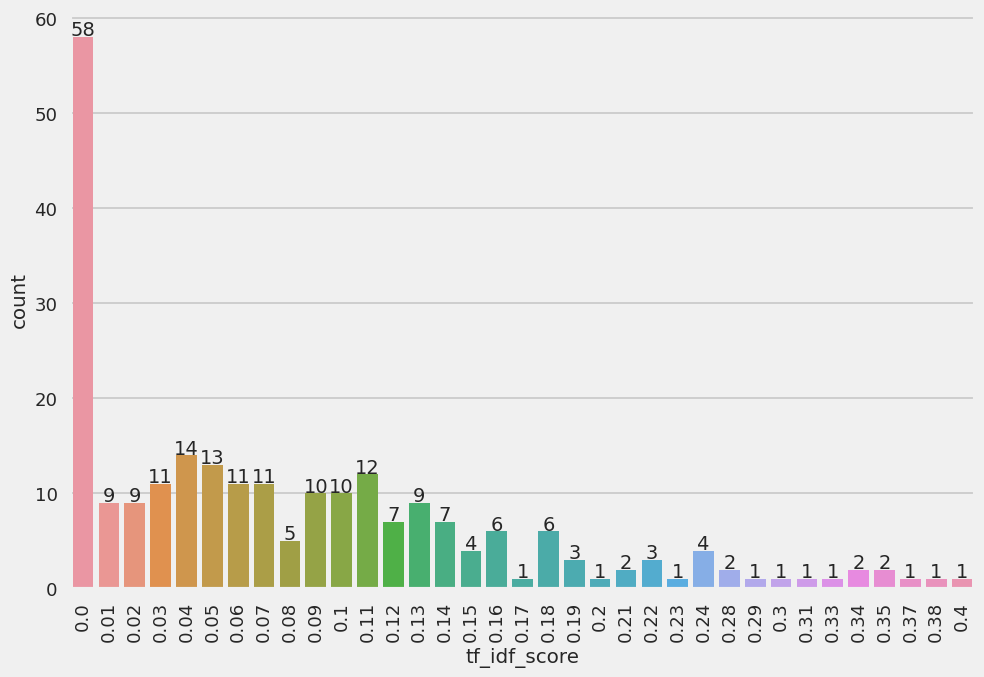

In [291]:
## valid 에 대해서도 확인해보기

from tqdm import tqdm

valid_df['tf_idf_score'] = [0.0]*len(valid_df)
for idx, row in tqdm(valid_df.iterrows(), desc="tf_idf 점수 계산중입니다"):
    # if idx > 5: break
    query_test = row['question']
    ground_truth = row['context']

    query_vec = vectorizer.transform([query_test])
    doc_vec = vectorizer.transform([ground_truth])
    result = query_vec*doc_vec.T
    #print(result.data.shape, result.data[0], result.data.size)
    
    if result.data.size:
        valid_df.loc[idx, 'tf_idf_score'] = round(result.data[0], 2)
    else:
        valid_df.loc[idx, 'tf_idf_score'] = 0.0
        
# train tf idf 시각화

ax = sns.countplot(x=valid_df['tf_idf_score'], data=valid_df)
for p in ax.patches:
    ax.annotate(text=format(p.get_height(), '.0f'), 
                xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 5), 
                textcoords = 'offset points',
                )

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)